In [3]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import plotly.express as px

In [5]:
def label_encoding(Dataframe:"pd.core.frame.DataFrame",column_name_list:list):
    for column_name in column_name_list:    
        unique_value_array=np.sort(Dataframe[column_name].unique())
        for index,value in enumerate(unique_value_array):
            Dataframe[column_name].replace(value,index,inplace=True)
    return Dataframe
def one_and_hot(Dataframe:"pd.core.frame.DataFrame",column_name_list:list):
    for column_name in column_name_list:
        for value in Dataframe[column_name].unique():
            Dataframe[column_name+'='+value]=[True if x==value else False for x in Dataframe[column_name]]
        Dataframe.drop(labels=[column_name],axis=1,inplace=True)
    return Dataframe
def confusion_matrix(y_true,y_pred):
    '''
    y_true: np.array of true labels
    y_pred: np.array of prediction labels
    returns a matrix of shape (2,2) in form [[TP,FP],
                                             [FN,TN]]
    '''
    conf_matrix=np.zeros((2,2),dtype=int)
    conf_matrix[0,0]=np.sum(np.logical_and(y_pred,y_true)) ##tp
    conf_matrix[1,1]=np.sum(np.logical_and(np.logical_not(y_pred),np.logical_not(y_true))) ## tn
    conf_matrix[0,1]=np.sum(np.where(y_pred-y_true>0,1,0)) ##fp
    conf_matrix[1,0]=len(y_true)-np.sum(conf_matrix) #fn
    return conf_matrix
def summary_report(y_true,y_pred):
    '''
    y_true: binary array of actual classes
    y_pred: binary array of predicted classes
    returns: a dataframe containing the classification report
    '''
    confusion_mat=confusion_matrix(y_true,y_pred)
    accuracy=np.sum(confusion_mat.diagonal())/np.sum(confusion_mat)
    N=np.sum(confusion_mat)
    count_1=sum(confusion_mat[:,0])
    count_0=sum(confusion_mat[:,1])
    support=[count_1,count_0,N,N,N]
    precision_1=confusion_mat[0,0]/sum(confusion_mat[0])
    precision_0=confusion_mat[1,1]/sum(confusion_mat[1])
    recall_1=confusion_mat[0,0]/sum(confusion_mat[:,0])
    recall_0=confusion_mat[1,1]/sum(confusion_mat[:,1])
    f1_score_1=(2*precision_1*recall_1)/(precision_1+recall_1)
    f1_score_0=(2*precision_0*recall_0)/(precision_0+recall_0)
    f1_scores=[f1_score_1,f1_score_0,accuracy,np.average([f1_score_1,f1_score_0]),(f1_score_1*count_0+f1_score_0*count_1)/N]
    precisions=[precision_1,precision_0,'',np.average([precision_0,precision_1]),(precision_0*count_0+precision_1*count_1)/N]
    recalls=[recall_1,recall_0,'',np.average([recall_0,recall_1]),(recall_0*count_0+recall_1*count_1)/N]
    return pd.DataFrame({
            '':['1','0','accuracy','macro average','weighted average'],
            'precision':precisions,
            'recall':recalls,
            'f1-score':f1_scores,
            'support':support
            })
class CustomRandomForest:
    def __init__(self, n_estimators=10, max_depth=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y,features:int=None):
        if(type(features))==type(None):
            features=X.shape[0]
        for _ in range(self.n_estimators):
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            indices=np.random.choice(X.shape[0],replace=True,size=X.shape[0])
            features_1=random.randint(3,features)
            column_indices=np.random.choice(X.shape[1],replace=False,size=features_1)
            tree.fit(X[indices][:,column_indices], y.reshape(y.size,1)[indices])
            self.trees.append((tree,column_indices))

    def predict(self, X):
        predictions = []
        for tree,column_indices in self.trees:
            predictions.append(tree.predict(X[:,column_indices]))
        # Handle potential voting strategies (e.g., majority vote)
        final_predictions = np.mean(predictions, axis=0).round()
        return final_predictions
class SVM:
    def __init__(self,C=1.0) -> None:
        self.C=C
        self.w=0
        self.b=0
    def loss_function(self,X,Y): ##hingeloss
        '''
        Calculates the hingeloss
        X: array of data points
        Y: array of labels
        '''
        w=self.w
        reg = 0.5 * (w * w)
        ls=[]
        for i in range(X.shape[0]):
            # Optimization term
            opt_term = Y[i] * ((np.dot(w, X[i])) + self.b)

            # calculating loss
            loss = reg + self.C * max(0, 1-opt_term)
            ls.append(loss)
        return np.sum(np.array(ls))
        # regularizer=0.5*self.w*self.w
        # print(regularizer)
        # output=np.array([Y[i]*((np.dot(self.w,X[i])+self.b)) for i in range(X.shape[0])])
        # loss=[regularizer+self.C*np.max(0,1-output_i) for output_i in output]
        # return loss[0,0]
    def fit(self,X,Y,batch_size:int=150,learning_rate:float=0.001,epochs:int=1000):
        '''
        Fits the classifier to the data. Uses stochastic gradient descent
        X: array of data points
        Y: array of labels
        batch_size: size of batch for stochastic gradient descent
        learning_rate: size of the change in weights and bias proportional to gradient per iteration
        epochs: Number of iterations of updates made using a sample of size=batch_size
        '''
        num_samples,num_features=X.shape
        if batch_size>num_samples:
            batch_size=num_samples
        sample_indices=np.random.choice(num_samples,size=num_samples,replace=False) ##shuffling the data for stochastic gradient descent
        losses=[] ##list to keep track of losses every epoch
        self.w=np.zeros((1,num_features))
        self.b=0
        for _ in range(epochs):
            loss=self.loss_function(X,Y)
            losses.append(loss)
            for batch in range(0,num_samples,batch_size):
                nabla_w=0   #gradient of w
                nabla_b=0   #gradient of b
                # for i in range(batch,min(batch+batch_size,num_samples)):
                #     x=sample_indices[i]
                #     dist=Y[x]*(np.dot(self.w,X[x].T)+self.b)
                #     if dist<=1:
                #         nabla_w+=self.C*Y[x]*X[x]
                #         nabla_b+=self.C*Y[x]
                # 
                x=sample_indices[[i for i in range(batch,max(batch+batch_size,num_samples))]]
                dist=Y[x]*(np.dot(self.w,X[x].T)+self.b)
                dist=np.where(dist<=1,1,0)
                nabla_w=sum(dist*self.C*Y[x]@X[x])
                nabla_b=np.sum(dist*self.C*Y[x])
                #
                self.w-=learning_rate*(self.w-nabla_w)
                self.b+=learning_rate*nabla_b
        self.losses=losses
    def predict(self,X):
        '''
        X: datapoint/s to be predicted
        returns 1 or -1 as a binary classifier
        '''
        return np.sign(np.dot(X,self.w[0])+self.b)

Reading the data and making a balanced sample of 8000 sentences using it

In [4]:
data=pd.read_csv(r'E:\Current_Workspace\Programming\SVM\IMDB Dataset.csv')
data=label_encoding(data,column_name_list=['sentiment'])
sample_size=8000
data_1=data[data.sentiment==1].iloc[:sample_size//2]
data_0=data[data.sentiment==0].iloc[:sample_size//2]
data_new=pd.concat([data_0,data_1],axis=0)
X=data_new.review
y=data_new.sentiment
X_train, X_test, y_train, y_test = train_test_split(data_new.review,data_new.sentiment, test_size=0.2, random_state=42)

vectorizing the train and test data

In [5]:
vectorizer=TfidfVectorizer()
X_train=vectorizer.fit_transform(X_train)
transformed_test=vectorizer.transform(X_test)
X_test=vectorizer.transform(X_test)
y_test=y_test.to_numpy()

Storing the vectorizer

In [6]:
# pickle.dump(vectorizer,open('vectorizer_tfid.pkl','wb'))

# SVM

In [8]:
text_classifier=SVC(C=2.15,kernel='rbf')
text_classifier.fit(X=X_train,y=y_train)
# vectorizer=pickle.load(open(r'E:\Current_Workspace\Programming\SVM\Pickle\Main Models\vectorizer_tfid.pkl','rb'))
# text_classifier=pickle.load(open(r'C:\Users\admin\Documents\Current_Workspace\Programming\SVM\classifier_SVM.pkl','rb'))
y_pred=text_classifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
summary_report(y_test,y_pred).style.hide()

[[709 116]
 [ 87 688]]


,precision,recall,f1-score,support
1,0.859394,0.890704,0.874769,796
0,0.887742,0.855721,0.871438,804
accuracy,,,0.873125,1600
macro average,0.873568,0.873212,0.873103,1600
weighted average,0.873639,0.873125,0.873111,1600


In [ ]:
# saving the model
# pickle.dump(text_classifier,open('classifier_SVM.pkl','wb'))
# Grid search CV
# search_space={'C':np.arange(0.5,3,0.1),
            #   'kernel':['linear','rbf'],}
# GS=GridSearchCV(estimator=SVC(),
#                 param_grid=search_space,
#                 scoring='accuracy',
#                 cv=5,
#                 n_jobs=8)
# GS.fit(X_train,y_train)
# GS.best_estimator_.get_params()
# best_SVM=GS.best_estimator_

# Naive Bayes

In [9]:
naive_bayes = MultinomialNB(alpha=1.17)
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)
print(confusion_matrix(y_test,y_pred))
summary_report(y_test,y_pred).style.hide()

[[628  76]
 [168 728]]


,precision,recall,f1-score,support
1,0.892045,0.788945,0.837333,796
0,0.812500,0.905473,0.856471,804
accuracy,,,0.847500,1600
macro average,0.852273,0.847209,0.846902,1600
weighted average,0.852074,0.847500,0.846854,1600


In [13]:
# saving model
# pickle.dump(naive_bayes,open('classifier_NaiveBayes.pkl','wb'))
# search_space={'alpha':np.arange(0.1,10,0.01)}
# GS=GridSearchCV(estimator=SVC(),
#                 param_grid=search_space,
#                 scoring='accuracy',
#                 cv=5,
#                 n_jobs=8)
# GS.fit(X_train,y_train)
# GS.best_estimator_.get_params()
# best_NB=GS.best_estimator_

# Random Forest Built In

In [10]:
rf=RandomForestClassifier()
rf = RandomForestClassifier(n_estimators=130, random_state=42,max_depth=17)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
summary_report(y_test,y_pred).style.hide()

[[659 142]
 [137 662]]


,precision,recall,f1-score,support
1,0.822722,0.827889,0.825297,796
0,0.828536,0.823383,0.825951,804
accuracy,,,0.825625,1600
macro average,0.825629,0.825636,0.825624,1600
weighted average,0.825643,0.825625,0.825623,1600


In [14]:
# saving model
# pickle.dump(rf,open('classifier_RandomForestBuiltIn.pkl','wb'))
# search_space={'n_estimators':np.array(range(50,150,10)),
#               'random_state':[42],
#               'max_depth':np.concatenate([[-1],range(2,21)]),
#               'criterion':['gini','entropy']}
# GS=GridSearchCV(estimator=RandomForestClassifier(),
#                 param_grid=search_space,
#                 scoring='accuracy',
#                 cv=5,
#                 n_jobs=6
#                 )
# GS.fit(X_train,y_train)
# GS.best_estimator_.get_params()
# best_RF=GS.best_estimator_


# Custom Random Forest

In [11]:
y_train=y_train.to_numpy()
custrf=CustomRandomForest(130)
custrf.fit(X_train, y_train)
y_pred=custrf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
summary_report(y_test,y_pred).style.hide()

[[634 166]
 [162 638]]


,precision,recall,f1-score,support
1,0.792500,0.796482,0.794486,796
0,0.797500,0.793532,0.795511,804
accuracy,,,0.795000,1600
macro average,0.795000,0.795007,0.794999,1600
weighted average,0.795013,0.795000,0.794996,1600


# Custom test input

In [12]:
review='The movie was uninteresting'
# review='This movie was not interesting. It could have been more entertaining. This was a total waste of time.'
# review='This movie was interesting. It was fun.'
print(f'The review was {"positive" if (text_classifier.predict(vectorizer.transform([review].__iter__()))) else "negative"}')

The review was negative


### Demonstration of self built SVM code

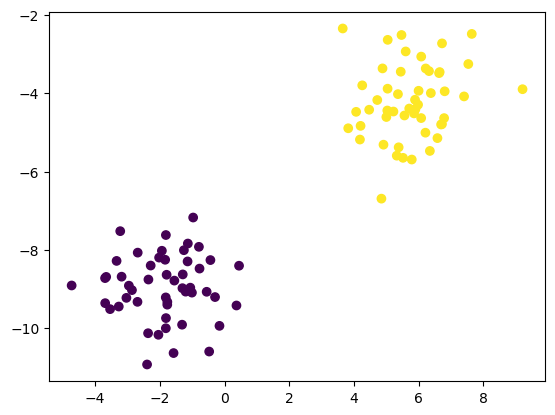

In [21]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Creating dataset
X, y = datasets.make_blobs(

        n_samples = 100, # Number of samples
        n_features = 2, # Features
        centers = 2,
        cluster_std = 1,
        random_state=40
    )

# Classes 1 and -1
y = np.where(y == 0, -1, 1)
plt.scatter(X[:, 0], X[:, 1], c=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
svm=SVM(C=5)
svm.fit(X_train,y_train,epochs=2000)
prediction = svm.predict(X_test)
lss = svm.losses.pop()
w,b=svm.w,svm.b

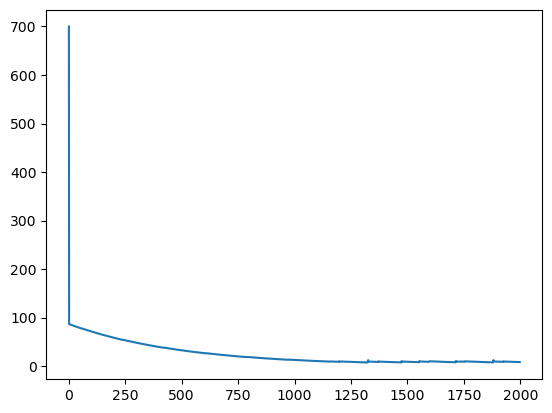

In [22]:
plt.plot(svm.losses)

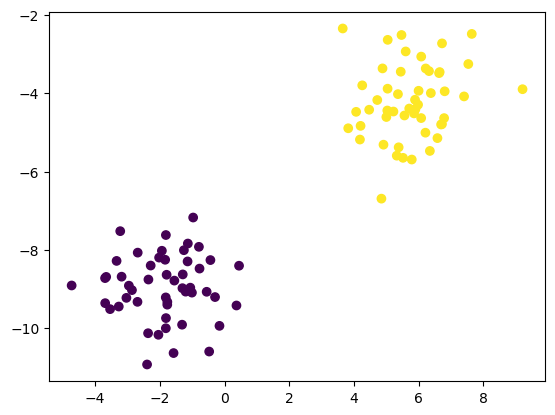

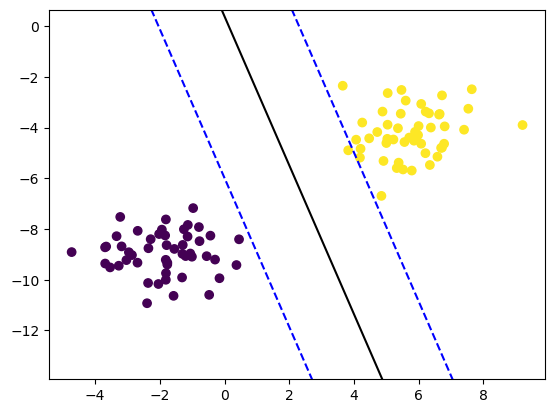

In [23]:
def visualize_dataset(X,y):
    '''
    X: 2D array of datapoints
    y: 1D array of labels 
    '''
    plt.scatter(X[:, 0], X[:, 1], c=y)


# Visualizing SVM
def visualize_svm(X,y,svm:SVM):
    def get_hyperplane_value(x, w, b, offset):
        return (-w[0][0] * x + b + offset) / w[0][1]

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.scatter(X[:, 0], X[:, 1], marker="o", c=y)

    x0_1 = np.amin(X[:, 0])
    x0_2 = np.amax(X[:, 0])

    x1_1 = get_hyperplane_value(x0_1, svm.w, svm.b, 0)
    x1_2 = get_hyperplane_value(x0_2, svm.w, svm.b, 0)

    x1_1_m = get_hyperplane_value(x0_1, svm.w, svm.b, -1)
    x1_2_m = get_hyperplane_value(x0_2, svm.w, svm.b, -1)

    x1_1_p = get_hyperplane_value(x0_1, svm.w, svm.b, 1)
    x1_2_p = get_hyperplane_value(x0_2, svm.w, svm.b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "k")
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "b--")
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "b--")

    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])

    plt.show()


visualize_dataset(X,y)
visualize_svm(X,y,svm)